In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from itertools import combinations

import matplotlib.pyplot as plt

In [2]:
gb = pd.read_csv("Data/csv/GB_10yr_2000.csv")
jpy = pd.read_csv("Data/csv/JPY_10yr_2000.csv")
ger = pd.read_csv("Data/csv/GER_10yr_2000.csv")
usd = pd.read_csv("Data/csv/US10_yr_2000.csv")

gb_series = gb['PX_LAST']
jpy_series = jpy['PX_LAST']
ger_series = ger['PX_LAST']
usd_series = usd['PX_LAST']

gb_series.name = 'GB 10yr'
jpy_series.name = 'JPY 10yr'
ger_series.name = 'GER 10yr'
usd_series.name = 'US 10yr'

coint_pairs = []
coint_pairs.append((gb_series[:5911], jpy_series[:5911]))
coint_pairs.append((ger_series[:5911], gb_series[:5911]))
coint_pairs.append((usd_series[:5911], ger_series[:5911]))

In [3]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    # adfuller (augmented dicky fuller test) is a statistically significant test for stationary dataset
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

p-value = 0.038021369895216116 The series GB 10yr - 3.153806293353844 * JPY 10yr is likely stationary.
p-value = 0.5445426807800632 The series GER 10yr - 0.8126886719496381 * GB 10yr is likely non-stationary.
p-value = 0.6594750597808761 The series US 10yr - 1.1007319584030395 * GER 10yr is likely non-stationary.


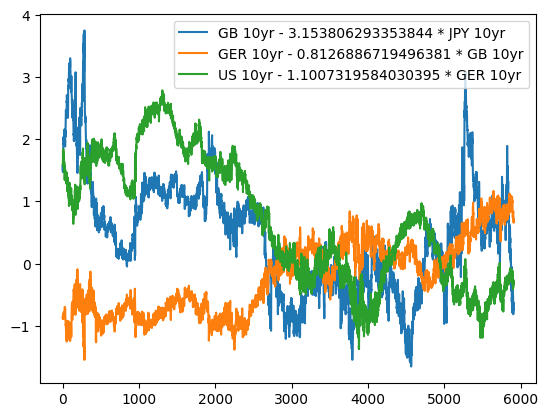

In [10]:
legend_labels = [] 
for pair in coint_pairs:
    model = sm.OLS(pair[0], pair[1]).fit()
    model.summary()
    beta = model.params.iloc[0]
    series = pair[0] - beta * pair[1]
    series.name = f"{pair[0].name} - {beta} * {pair[1].name}"
    stationary = check_for_stationarity(series, 0.05)
    plt.plot(pair[0].index, pair[0] - beta * pair[1])
    legend_labels.append(series.name)

plt.legend(legend_labels)


# Index Coint Pairs

In [5]:
Asia_Pac_index = pd.read_csv("Data/csv/AsiaPacAggIdx_2000.csv")
EM_index = pd.read_csv("Data/csv/EMAggIdx_2000.csv")
Global_Agg_index = pd.read_csv("Data/csv/GlobalAggIdx_2000.csv")
PanEuro_Index = pd.read_csv("Data/csv/PanEuroAggIdx_2000.csv")
US_index = pd.read_csv("Data/csv/USAggIdx_2000.csv")

In [6]:
series_list = []
Asia_Pac_series = Asia_Pac_index['PX_LAST']
Asia_Pac_series.name = 'Asia_Pac'
Asia_Pac_series.index = Asia_Pac_index['Date']
EM_series = EM_index['PX_LAST']
EM_series.name = 'EM'
EM_series.index = EM_index['Date']
Global_Agg_series = Global_Agg_index['PX_LAST']
Global_Agg_series.name = 'Global_Agg'
Global_Agg_series.index = Global_Agg_index['Date']
PanEuro_series = PanEuro_Index['PX_LAST']
PanEuro_series.name = 'PanEuro'
PanEuro_series.index = PanEuro_Index['Date']
US_series = US_index['PX_LAST']
US_series.name = 'US'
US_series.index = US_index['Date']

series_list.append(Asia_Pac_series)
series_list.append(EM_series)
series_list.append(Global_Agg_series)
series_list.append(PanEuro_series)
series_list.append(US_series)


# normalize series length to 5756
coint_series = []
for series in series_list:
    coint_series.append(series[:5756])


            Asia_Pac         EM  Global_Agg   PanEuro       US
Date                                                          
11/2/2023   173.8605  1082.1510    436.1851  205.9037  2023.84
11/1/2023   173.4825  1072.1280    432.8777  205.1713  2011.47
10/31/2023  173.8414  1067.2630    430.8629  204.5729  1992.08
10/30/2023  172.6046  1066.9990    432.3659  204.1771  1994.02
10/27/2023  172.9983  1066.9950    432.0305  204.0118  1998.02
...              ...        ...         ...       ...      ...
9/20/2001   104.8248   270.3807    230.3859  111.8395  1000.97
9/19/2001   105.0372   273.0812    230.3825  111.9485  1002.88
9/18/2001   105.2391   272.3380    229.6488  111.9995  1000.49
9/17/2001   105.3222   271.3409    229.7707  112.1008  1003.56
9/14/2001   105.0259   276.5722    230.1519  112.2101  1005.61

[5339 rows x 5 columns]
[('Asia_Pac', 'EM'), ('Asia_Pac', 'Global_Agg'), ('Asia_Pac', 'PanEuro'), ('Asia_Pac', 'US'), ('EM', 'Global_Agg'), ('EM', 'PanEuro'), ('EM', 'US'), ('Globa

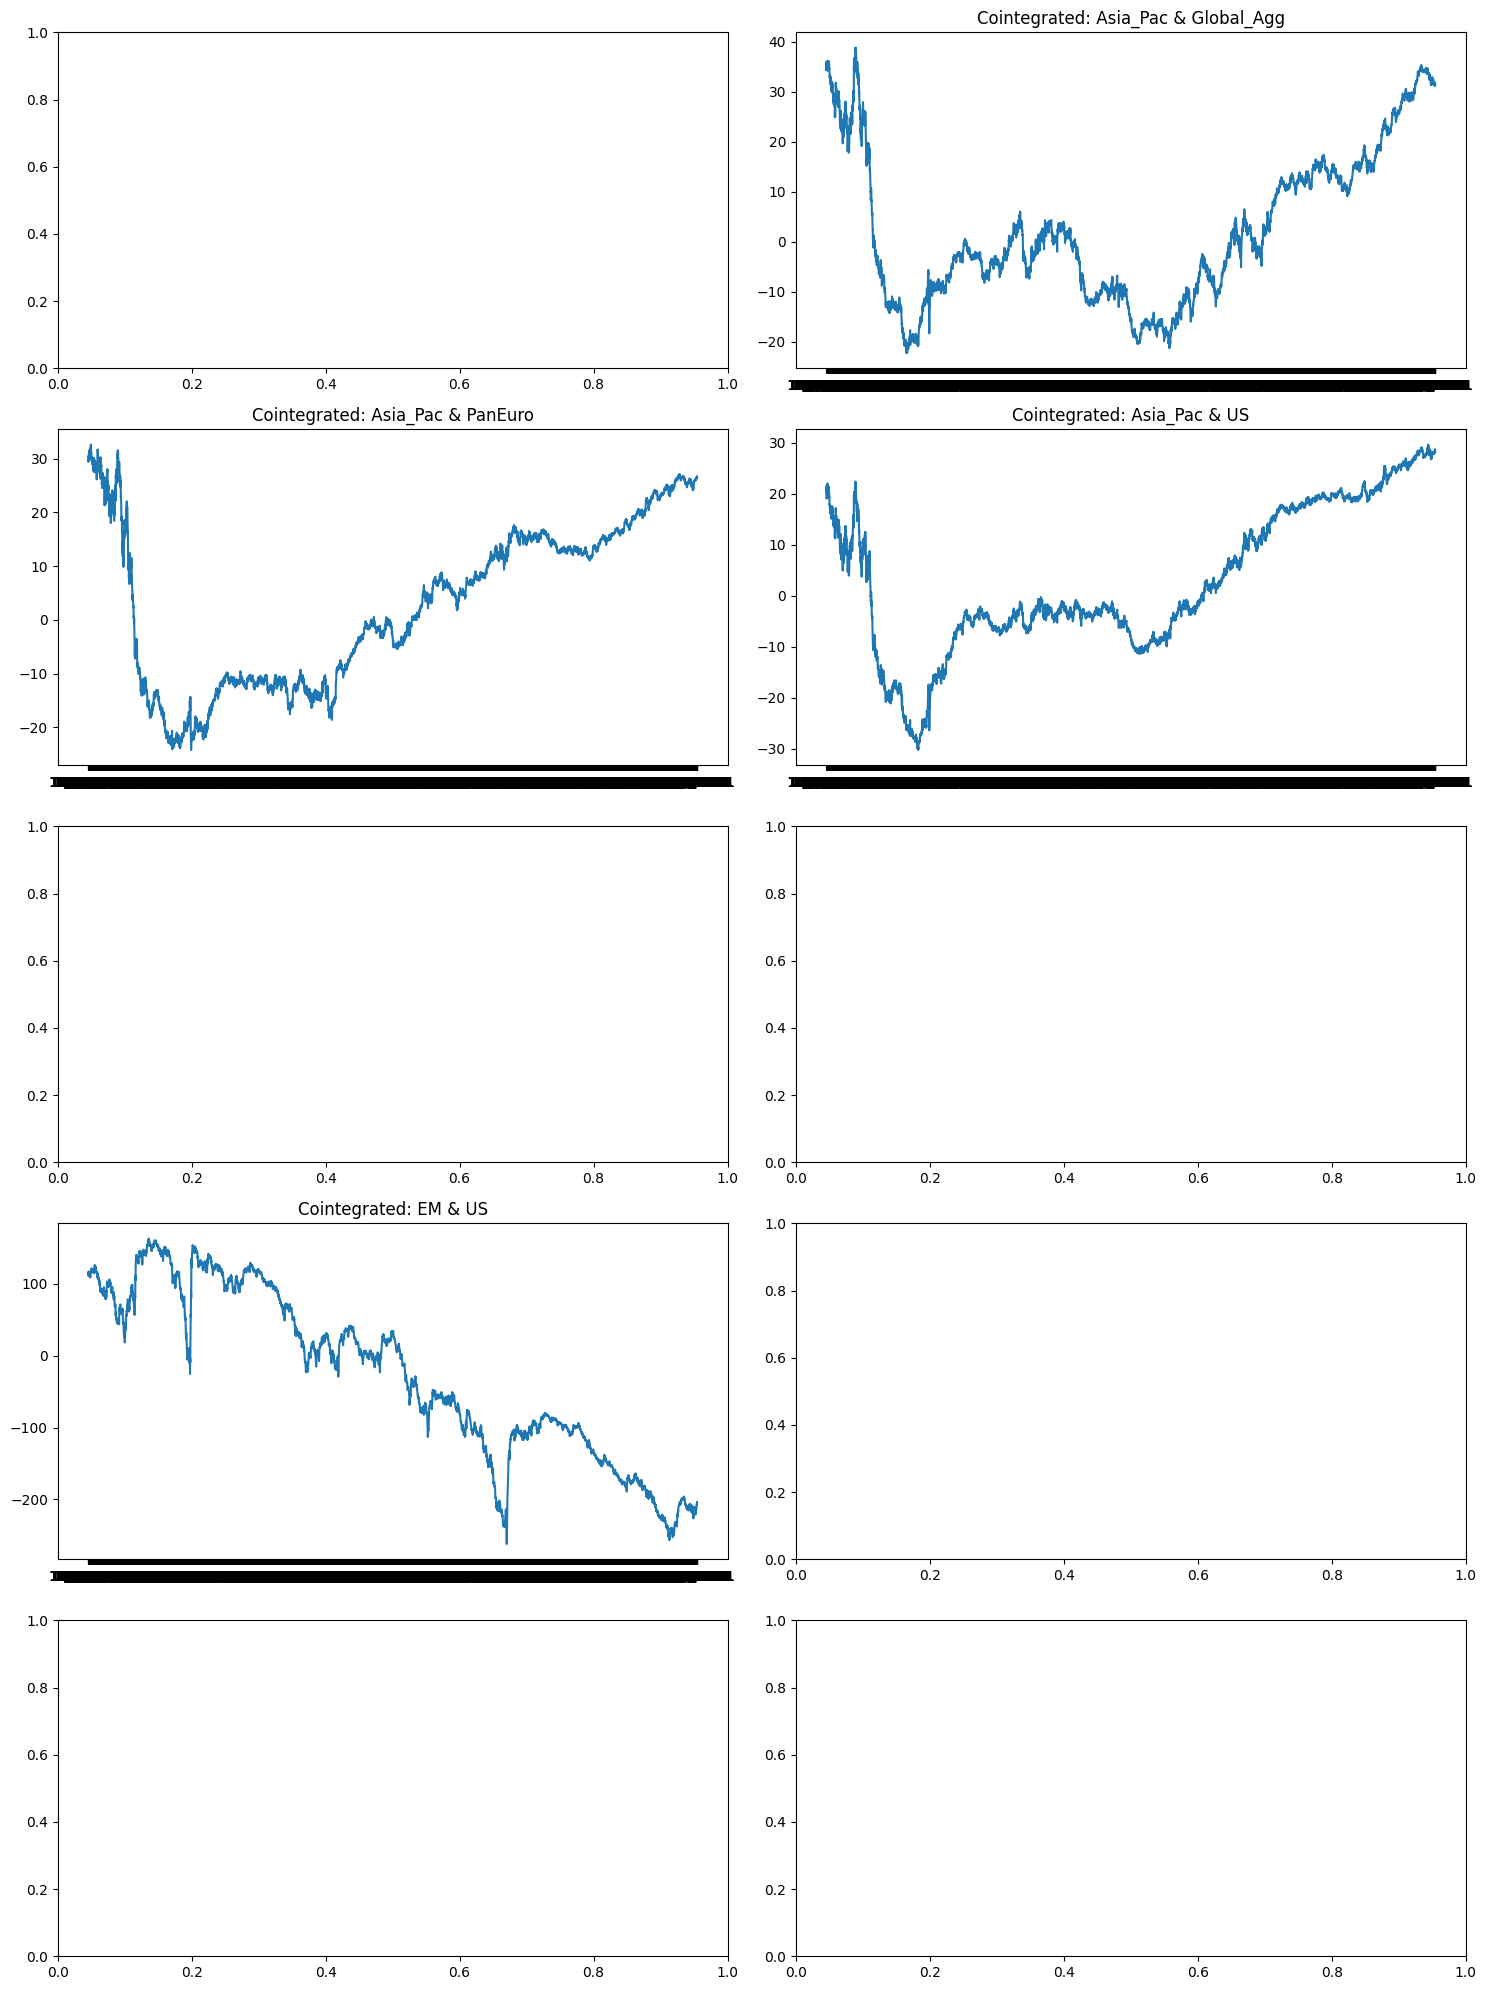

In [7]:
# Align all series to the same date index first
aligned_data = pd.concat(coint_series, axis=1, join='inner')
print(aligned_data)
pairs = list(combinations(aligned_data.columns, 2))
print(pairs)

fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Process each pair and plot if necessary
for i, pair in enumerate(pairs):
    series1 = aligned_data[pair[0]]
    series2 = aligned_data[pair[1]]
    print(series1)
    
    coint_t, p_val, _ = coint(series1, series2)
    
    if p_val < .05:
        model = sm.OLS(series1, series2).fit()
        beta = model.params.iloc[0]
        series_diff = series1 - beta * series2
        series_diff.name = f"{pair[0]} - {beta:.2f} * {pair[1]}"
        
        check_for_stationarity(series_diff)
        
        axs[i].plot(series_diff.index, series_diff, label=series_diff.name)
        axs[i].set_title(f"Cointegrated: {pair[0]} & {pair[1]}")    
    else:
        print(f"Not Cointegration: {p_val}: {pair[0]}, {pair[1]}")


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()